In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터 확인
df = pd.read_csv('FIFA_train.csv')
print(df.shape)
df.head()

(8932, 12)


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


# value와의 상관계수가 높은 순서(연속형)
1. stat_overall
2. reputation
3. stat_potential
4. stat_skill_moves
5. age

In [4]:
def func(string:object) -> int:
    string = string[-4:]
    return int(string)
df['contract_until'] = df['contract_until'].apply(func)

In [12]:
# 필요없는 피쳐 삭제 및 정수 인코딩
from sklearn.preprocessing import LabelEncoder

pos = df['position'].values
le = LabelEncoder()
df['position'] = le.fit_transform(pos)

continent = df['continent'].values

df['continent'] = le.fit_transform(continent)
df['continent'].astype('category')

foot = df['prefer_foot'].values
le = LabelEncoder()
df['prefer_foot'] = le.fit_transform(foot)


# df = df.drop(['contract_until', 'prefer_foot', 'continent', 'stat_skill_moves', 'age'], axis = 1)
df.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,4,2021,3,0,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,2,2020,1,1,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,4,2021,3,1,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,2,2020,0,1,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,2,2021,1,1,3.0,90,93,1.0,68000000.0


In [13]:
# 데이터 분할

X = np.zeros(len(df)*9).reshape(len(df), 9)
# age 부터 skill_moves 까지를 X로 설정
for i,col in enumerate(df.columns[2:-1]) :
  X[:,i] =  df[col].values
y = df['value'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,
                                                    random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7145, 9), (1787, 9), (7145,), (1787,))

# 하이퍼 파라미터 튜닝

In [17]:
# 정규화 -> LGBM 적용 pipe 생성
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display = 'diagram')
pipe_lgbm = make_pipeline(StandardScaler(),
                          LGBMRegressor(n_estimators=400, randomstate=1, metric = 'mse'))
pipe_lgbm.fit(X_train, y_train)
pipe_lgbm

[LightGBM] [Warning] Unknown parameter: randomstate


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor',
                 LGBMRegressor(metric='mse', n_estimators=400, randomstate=1))])

In [18]:
pipe_lgbm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'lgbmregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'lgbmregressor__boosting_type', 'lgbmregressor__class_weight', 'lgbmregressor__colsample_bytree', 'lgbmregressor__importance_type', 'lgbmregressor__learning_rate', 'lgbmregressor__max_depth', 'lgbmregressor__min_child_samples', 'lgbmregressor__min_child_weight', 'lgbmregressor__min_split_gain', 'lgbmregressor__n_estimators', 'lgbmregressor__n_jobs', 'lgbmregressor__num_leaves', 'lgbmregressor__objective', 'lgbmregressor__random_state', 'lgbmregressor__reg_alpha', 'lgbmregressor__reg_lambda', 'lgbmregressor__silent', 'lgbmregressor__subsample', 'lgbmregressor__subsample_for_bin', 'lgbmregressor__subsample_freq', 'lgbmregressor__randomstate', 'lgbmregressor__metric'])

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1)).flatten()
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1)).flatten()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7145, 9) (1787, 9) (7145,) (1787,)


In [15]:
# 모델 성능 평가 함수 생성

def regression_scores(y_true, y_pred) :
  import numpy as np
  from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
  
  RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
  R2 = r2_score(y_true, y_pred)
  return { 
          'RMSE' : np.round(RMSE, 3),
          'R2' : np.round(R2, 3)}

In [16]:
# 그리드 서치
from sklearn.model_selection import GridSearchCV
param_grid = { 'lgbmregressor__max_depth':[3,5,8], 
               'lgbmregressor__learning_rate' : [0.1,0.01]}

gs = GridSearchCV(estimator = pipe_lgbm,
                  scoring = 'accuracy',
                  cv = 5,  # 5겹 교차검증
                  param_grid = param_grid,
                  refit = True,  # 훈련후 바로 적용
                  return_train_score = True # 훈련 성능 리턴
                  )
gs.fit(X_train, y_train)
print(f'최적의 하이퍼파라미터 세트:{gs.best_params_}')

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

In [20]:
lgbm1 = LGBMRegressor(max_depth = 3, learning_rate = 0.1,
                     metric = 'mse', randomstate=1)
lgbm1.fit(X_train, y_train)
y_pred = lgbm1.predict(X_test)
regression_scores(y_test, y_pred)

{'RMSE': 0.1, 'R2': 0.99}

In [20]:
# 그리드 서치
from sklearn.model_selection import GridSearchCV
param_grid = { 'lgbmregressor__max_depth':[3,5,8], 
               'lgbmregressor__learning_rate' : [0.1,0.01],'lgbmregressor__num_leaves':[20,40,60,80,100], 'lgbmregressor__min_child_samples':[5,10,15]}

gs = GridSearchCV(estimator = pipe_lgbm,
                  scoring = 'accuracy',
                  cv = 5,  # 5겹 교차검증
                  param_grid = param_grid,
                  refit = True,  # 훈련후 바로 적용
                  return_train_score = True # 훈련 성능 리턴
                  )
gs.fit(X_train, y_train)
print(f'최적의 하이퍼파라미터 세트:{gs.best_params_}')

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

In [21]:
lgbm2 = LGBMRegressor(max_depth = 3, learning_rate = 0.1,min_child_samples=5, num_leaves=20,
                     metric = 'mse', randomstate=1)
lgbm2.fit(X_train, y_train)
y_pred = lgbm2.predict(X_test)
regression_scores(y_test, y_pred)

[LightGBM] [Warning] Unknown parameter: randomstate


{'RMSE': 0.089, 'R2': 0.992}

In [22]:
param_grid = {'lgbmregressor__num_leaves':[20,40,60,80,100], 'lgbmregressor__min_child_samples':[5,10,15],'lgbmregressor__max_depth':[-1,5,10,20],
             'lgbmregressor__learning_rate':[0.05,0.1,0.2],'lgbmregressor__reg_alpha':[0,0.01,0.03]}

gs = GridSearchCV(estimator = pipe_lgbm,
                  scoring = 'accuracy',
                  cv = 5,  # 5겹 교차검증
                  param_grid = param_grid,
                  refit = True,  # 훈련후 바로 적용
                  return_train_score = True # 훈련 성능 리턴
                  )
gs.fit(X_train, y_train)
print(f'최적의 하이퍼파라미터 세트:{gs.best_params_}')

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
[LightGBM] [Warning] Unknown parameter: randomstate
최적의 하이퍼파라미터 세트:{'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__max_depth': -1, 'lgbmregressor__min_child_samples': 5, 'lgbmregressor__num_leaves': 20, 'lgbmregressor__reg_alpha': 0}


In [26]:
lgbm3 = LGBMRegressor(max_depth = -1, n_estimate = 400, learning_rate = 0.05,min_child_samples=5,num_leaves=20,reg_alpha=0,
                     metric = 'mse', randomstate=1)
lgbm3.fit(X_train, y_train)# 모델 성능 평가
y_pred = lgbm3.predict(X_test)
regression_scores(y_test, y_pred)

[LightGBM] [Warning] Unknown parameter: n_estimate
[LightGBM] [Warning] Unknown parameter: randomstate


{'RMSE': 0.072, 'R2': 0.995}

In [23]:
test = pd.read_csv('FIFA_test.csv')
from sklearn.preprocessing import LabelEncoder
pos = test['position'].values
le = LabelEncoder()

pos = test['position'].values
le = LabelEncoder()
test['position'] = le.fit_transform(pos)

continent = test['continent'].values
le = LabelEncoder()
test['continent'] = le.fit_transform(continent)
test['continent'].astype('category')

foot = test['prefer_foot'].values
le = LabelEncoder()
test['prefer_foot'] = le.fit_transform(foot)

test['contract_until'] = test['contract_until'].apply(func)
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,2,2022,3,1,5.0,94,94,5.0
1,2,Neymar Jr,26,4,2022,3,1,5.0,92,93,5.0
2,4,K. De Bruyne,27,2,2023,2,1,4.0,91,92,4.0
3,5,E. Hazard,27,2,2020,3,1,4.0,91,91,4.0
4,6,L. Modrić,32,2,2020,2,1,4.0,91,91,4.0


In [24]:
X = np.zeros(len(test)*9).reshape(len(test), 9)
# age 부터 skill_moves 까지를 X로 설정
for i,col in enumerate(test.columns[2:]) :
  X[:,i] =  test[col].values

X.shape

(3828, 9)

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_pred = lgbm3.predict(X)
y_pred

array([11.67621566, 14.48059601, 12.42471565, ..., -0.44800536,
       -0.44538485, -0.44800536])

In [33]:
import shap
import skimage

In [34]:
explainer = shap.TreeExplainer(lgbm3) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

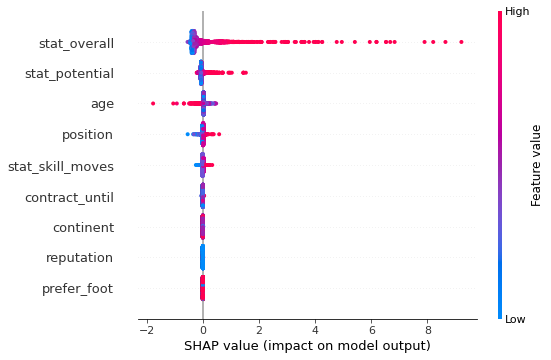

In [44]:
shap.summary_plot(shap_values, X_test, feature_names = ['age','continent','contract_until','position','prefer_foot','reputation','stat_overall','stat_potential','stat_skill_moves'])

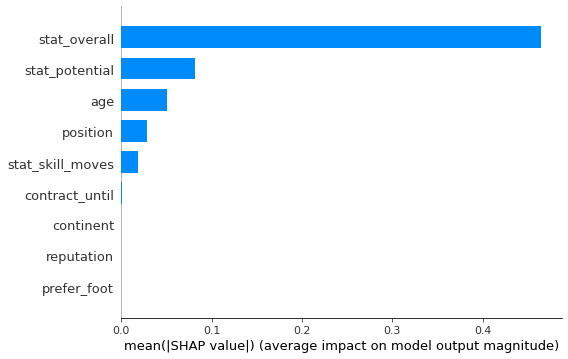

In [43]:
shap.summary_plot(shap_values, X_test, plot_type = "bar",feature_names = ['age','continent','contract_until','position','prefer_foot','reputation','stat_overall','stat_potential','stat_skill_moves'])

- stat_position - 'R2': 0.896,  'RMSE': 0.323

  - stat_position, continent - 'R2': 0.897, 'RMSE': 0.322

### continent의 영향이 미미하다는 것을 알 수 있다.

- reputation - 'R2': 0.445, 'RMSE': 0.745

- stat_potential - 'R2': 0.707, 'RMSE': 0.541



- 상위 3개(stat_position, stat_potential, reputation) - 'R2': 0.956,  'RMSE': 0.21

  - \+ age - 'R2': 0.973,  'RMSE': 0.165

  - age 대신 position - 'R2': 0.973, 'RMSE': 0.164

  - \+ age + position - 'R2': 0.99, 'RMSE': 0.101

### 이외의 값들은 영향이 거의 없다.

- 모든 특성 사용 - 'R2': 0.99 'RMSE': 0.102
## stat_overall, stat_potential, reputation = 많은 영향을 끼치는 중요한 특성
## age, position = 약간의 영향을 끼치는 특성